In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samples/submission_dept_store.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import gc
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

In [3]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
train_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
submission = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

In [4]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    train_data[col] = 0
    train_data[col] = train_data[col].astype(np.int16)

In [5]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [6]:
print("Downcasting data")
train_eva = downcast(train_data)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

Downcasting data


In [7]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]


In [8]:
print("Get Labels")
d_id = dict(zip(train_data["id"].cat.codes, train_data["id"]))
d_store = dict(zip(train_data["store_id"].cat.codes, train_data["store_id"]))
d_dept = dict(zip(train_data["dept_id"].cat.codes, train_data["dept_id"]))
d_cat = dict(zip(train_data["cat_id"].cat.codes, train_data["cat_id"]))

Get Labels


In [9]:
data.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'sell_price', 'snap', 'weekend', 'total_sale_store', 'total_sale_dept',
       'state_mean', 'store_mean', 'cat_mean', 'dept_mean', 'state_cat_mean',
       'state_dept_mean', 'store_cat_mean', 'item_id_mean', 'item_state_mean',
       'item_store_mean', 'state_median', 'store_median', 'cat_median',
       'dept_median', 'state_cat_median', 'state_dept_median',
       'store_cat_median', 'item_id_median', 'item_state_median',
       'item_store_median', 'state_std', 'store_std', 'cat_std', 'dept_std',
       'state_cat_std', 'state_dept_std', 'store_cat_std', 'item_id_std',
       'item_state_std', 'item_store_std', 'sales_lag_5', 'sales_lag_8',
       'sales_lag_10', 'sales_lag_25', 'sales_lag_26', 'sales_lag_27',
       'sales_lag_28', 'sales_lag_29', 'sales_lag_30', 'sales_lag_31',
       'sales_lag_32', 'sales_lag_33', 'sales_lag_3

In [10]:
data = data.drop(['sales_lag_5', 'sales_lag_8','sales_lag_10', 'sales_lag_25', 'sales_lag_26', 'sales_lag_27', 'rolling_mean_tmp_7_30',
                  'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7','rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30',
                  'rolling_mean_tmp_14_60',  'rolling_mean_tmp_1_7','rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30',
                  'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7','rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30',
                  'rolling_mean_tmp_7_60'], axis = 1)

In [11]:
# Create store dataframe for model predict total sale for store
def create_dept_dataframe(train_eva, dept):
    train = train_eva[train_eva["id"].str.contains(dept)]
  
    
    df = pd.melt(frame=train, 
                 id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name="d", value_name="sold")
    sum_df = df.groupby(["d", "dept_id"])["sold"].sum().reset_index()

    df = pd.merge(left=df.drop("sold", axis=1), right=sum_df, how="left", on=["d", "dept_id"])[["dept_id", "state_id", "d", "sold"]]
    
    df.drop_duplicates(inplace=True)
    
    df = pd.merge(left=df, right=calendar, how="left", on="d")
    
    
    df = df.drop(["dept_id", "state_id", "date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df["d"] = df["d"].str[2:].astype(np.int16)
    
    df["event_name_1"] = df["event_name_1"].cat.codes
    df["event_type_1"] = df["event_type_1"].cat.codes
    X_train, y_train = df[df["d"] < 1914].drop("sold", axis=1), df[df["d"] < 1914]["sold"]
    lgb_train_sets = lgb.Dataset(X_train, y_train)
    X_valid, y_valid = df[(df["d"] >= 1914) & (df["d"] < 1942)].drop("sold", axis=1), df[(df["d"] >= 1914) & (df["d"] < 1942)]["sold"]
    lgb_valid_sets = lgb.Dataset(X_valid, y_valid)
    X_test, y_test = df[df["d"] >= 1942].drop("sold", axis=1), df[df["d"] >= 1942]["sold"] 
    
    
    return lgb_train_sets,lgb_valid_sets, X_train, y_train, X_valid, y_valid, X_test, y_test

In [12]:
params = {"objective" : "tweedie",
        'boosting_type': 'gbdt',
        'learning_rate': 0.034,
        'max_depth' : 135,
        'num_leaves': 88,
        'n_estimators': 1000,
        'force_row_wise':True,
        'lambda_l2':1
}

In [13]:
def create_dept_model(train_data, dept_id):
    train_sets, valid_sets, X_train, y_train, X_valid, y_valid, X_test, y_test = create_dept_dataframe(train_data, dept_id)
    new_index = y_test.index.map(lambda x: x + 1)
    y_test.index = new_index

    dept_model = lgb.train(params=params,
                            train_set=train_sets,
                            valid_sets=valid_sets,
                            verbose_eval=50,
                            early_stopping_rounds=50)

    dept_preds = dept_model.predict(X_test)
    dept_preds_map = dict(pd.Series(dept_preds, index=y_test.index))

    return dept_preds_map

In [14]:
def train_and_predict(df, dept_id, dept_preds_map):
    df_dept= df[df["dept_id"] == dept_id]
    df_dept.loc[df_dept["d"] >= 1942, "total_sale_dept"] = df_dept.loc[df_dept["d"] >= 1942, :]["d"].map(dept_preds_map)

    # Create train set
    X_train, y_train = df_dept[df_dept['d'] < 1914].drop('sold', axis=1), df_dept[df_dept['d'] < 1914]['sold']
    train_sets = lgb.Dataset(X_train, y_train)

    X_valid, y_valid = df_dept[(df_dept['d'] >= 1914) & (df_dept['d'] < 1942)].drop('sold', axis=1), \
                       df_dept[(df_dept['d'] >= 1914) & (df_dept['d'] < 1942)]['sold']
    valid_sets = lgb.Dataset(X_valid, y_valid)

    X_test = df_dept[df_dept["d"] >= 1942].drop("sold", axis=1)

    model = lgb.train(params=params,
                      train_set=train_sets,
                      valid_sets=valid_sets,
                      verbose_eval=50,
                      early_stopping_rounds=50)

    pred_val = model.predict(X_valid)
    valid.loc[X_valid.index, "sold"] = pred_val

    pred_eva = model.predict(X_test)
    test.loc[X_test.index, "sold"] = pred_eva

    joblib.dump(model, f'model_dept_{dept_id}.pkl')
    del model, X_train, y_train, X_valid, y_valid, X_test, train_sets, valid_sets
    gc.collect()

In [15]:
for i in range(len(d_dept)):
    dept_preds_map = create_dept_model(train_data, d_dept[i])
    train_and_predict(data, i, dept_preds_map)

[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 5739, number of used features: 10
[LightGBM] [Info] Start training from score 7.885975
Training until validation scores don't improve for 50 rounds
[50]	valid_0's tweedie: 242.816
[100]	valid_0's tweedie: 242.873
Early stopping, best iteration is:
[60]	valid_0's tweedie: 242.779
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 4132080, number of used features: 53
[LightGBM] [Info] Start training from score 0.208112
Training until validation scores don't improve for 50 rounds
[50]	valid_0's tweedie: 4.81033
[100]	valid_0's tweedie: 4.82797
Early stopping, best iteration is:
[60]	valid_0's tweedie: 4.7996
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 5739, number of used features: 10
[LightGBM] [Info] Start training from score 8.291147
Training until validation scores don't improve for 50 rounds
[50]	valid_0's t

In [16]:
model = joblib.load("/kaggle/working/model_dept_0.pkl")

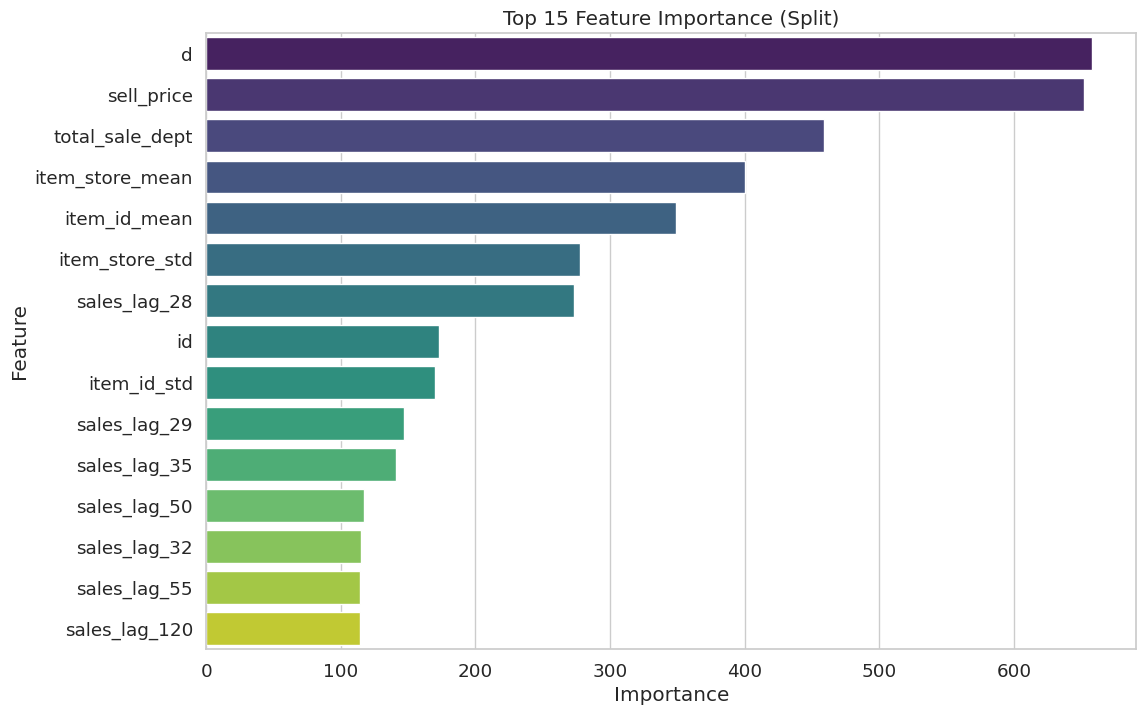

In [17]:
import seaborn as sns

# Get feature importances
feature_importance = pd.DataFrame({'Feature': model.feature_name(), 'Importance': model.feature_importance(importance_type='split')})
top_features = feature_importance.nlargest(15, 'Importance')

# Plot feature importance with Seaborn styling
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid", font_scale=1.2)

# Plot only the top 15 features with different colors
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

# Customize plot further if needed
plt.title('Top 15 Feature Importance (Split)')
plt.show()

In [18]:
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]

In [19]:
valid.head()

,id,d,sold
58327370,14370,1914,0
58327371,14380,1914,0
58327372,14390,1914,0
58327373,14400,1914,0
58327374,14410,1914,1


In [20]:
valid["id"] = valid["id"].map(d_id)
valid = valid.pivot(index="id", columns="d", values="sold").reset_index()
valid["id"] = valid["id"].str.replace("evaluation", "validation")

submission = submission[["id"]]

f_col = [f"F{i}" for i in range(1,29)]
f_col.insert(0, "id")

out_val = pd.merge(left=submission[:30490], right=valid, on="id")
out_val.columns=f_col


test["id"] = test["id"].map(d_id)
test = test.pivot(index="id", columns="d", values="sold").reset_index()

out_eva = pd.merge(left=submission[30490:], right=test, on="id")
out_eva.columns=f_col


submit = pd.concat([out_val,out_eva], ignore_index=True)

30490
30490


In [21]:
submit.to_csv('submission.csv',index=False)